In [382]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [383]:
pd.read_csv('sensor9y.csv').head()

,sensor,9y
0,0.039216,235.392
1,0.039216,236.682
2,0.039216,238.002
3,0.039216,237.996
4,0.039216,237.974


In [384]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('sensor9y.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,1].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [410]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros(len(data)-lookback)

for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i,1]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1,1)

In [411]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.2*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]

In [412]:
batch_size = 15

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [413]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [414]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [415]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [416]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [417]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/26....... Average Loss for Epoch: 0.24038799107074738
Epoch 1......Step: 2/26....... Average Loss for Epoch: 0.23522371798753738
Epoch 1......Step: 3/26....... Average Loss for Epoch: 0.19068264961242676
Epoch 1......Step: 4/26....... Average Loss for Epoch: 0.16856995411217213
Epoch 1......Step: 5/26....... Average Loss for Epoch: 0.16373073905706406
Epoch 1......Step: 6/26....... Average Loss for Epoch: 0.15780712539951006
Epoch 1......Step: 7/26....... Average Loss for Epoch: 0.14482344367674418
Epoch 1......Step: 8/26....... Average Loss for Epoch: 0.1375140631571412
Epoch 1......Step: 9/26....... Average Loss for Epoch: 0.12918279568354288
Epoch 1......Step: 10/26....... Average Loss for Epoch: 0.12458202093839646
Epoch 1......Step: 11/26....... Average Loss for Epoch: 0.1236514388160272
Epoch 1......Step: 12/26....... Average Loss for Epoch: 0.12248766111830871
Epoch 1......Step: 13/26....... Average Loss for Epoch: 0.1174377480

Epoch 5......Step: 2/26....... Average Loss for Epoch: 0.037504916079342365
Epoch 5......Step: 3/26....... Average Loss for Epoch: 0.028522684549291927
Epoch 5......Step: 4/26....... Average Loss for Epoch: 0.023208169382996857
Epoch 5......Step: 5/26....... Average Loss for Epoch: 0.021414245199412107
Epoch 5......Step: 6/26....... Average Loss for Epoch: 0.023698757324988644
Epoch 5......Step: 7/26....... Average Loss for Epoch: 0.02349053023915206
Epoch 5......Step: 8/26....... Average Loss for Epoch: 0.02326104271924123
Epoch 5......Step: 9/26....... Average Loss for Epoch: 0.02734177637224396
Epoch 5......Step: 10/26....... Average Loss for Epoch: 0.03160521532408893
Epoch 5......Step: 11/26....... Average Loss for Epoch: 0.035467401781881396
Epoch 5......Step: 12/26....... Average Loss for Epoch: 0.03422540220587204
Epoch 5......Step: 13/26....... Average Loss for Epoch: 0.03529972966330556
Epoch 5......Step: 14/26....... Average Loss for Epoch: 0.03643501187408609
Epoch 5......S

In [418]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.027336499999819353
sMAPE: 1.665032713984544%


In [419]:
print(gru_outputs)

[array([322.0044 , 332.08398, 344.42047, 354.39438, 359.90332, 356.98947,
       351.2814 , 336.67834, 321.92038, 305.14917, 281.638  , 269.6471 ,
       263.3659 , 257.77274, 252.98523, 249.36531, 246.35368, 245.0457 ,
       245.57619, 246.114  , 247.52296, 250.88249, 252.74754, 253.46306,
       253.09605, 252.44621, 252.14673, 252.10129, 251.88435, 253.17702,
       258.79175, 268.2616 , 265.0583 , 269.51703, 281.81714, 298.79675,
       318.97214, 337.31406, 349.87955, 358.0017 , 362.40167, 317.63596,
       269.97314, 243.80667, 237.64705, 237.63116, 240.15468, 243.42989,
       246.7187 , 249.47527, 251.62877, 251.6306 , 252.06288, 251.48708,
       251.99686, 253.86905, 256.79242, 261.89835, 268.17804, 276.44333,
       283.68304, 292.43924, 302.34857, 310.91156, 294.39432, 300.90445,
       314.0014 , 334.68225, 348.5983 , 361.7562 , 365.04337, 367.33154,
       364.83557, 357.85852, 352.00684, 308.4712 , 309.93744, 322.20657,
       330.9855 , 337.90186, 333.92035, 324.04   ,

In [420]:
print(targets)

[array([359.349, 356.727, 356.757, 352.848, 338.462, 334.534, 308.456,
       301.928, 284.943, 249.721, 266.714, 258.879, 247.109, 241.885,
       235.373, 228.841, 231.472, 235.396, 231.469, 237.975, 245.832,
       238.011, 237.993, 236.674, 236.709, 237.971, 237.971, 241.884,
       251.037, 266.685, 278.433, 241.89 , 283.674, 301.909, 314.987,
       333.268, 342.392, 346.318, 355.438, 359.319, 239.274, 235.355,
       240.586, 239.276, 239.29 , 240.58 , 239.274, 239.285, 237.995,
       239.291, 238.02 , 240.614, 235.374, 241.88 , 245.818, 248.441,
       256.25 , 260.193, 270.614, 271.94 , 283.67 , 292.798, 294.123,
       235.377, 311.06 , 313.645, 342.382, 335.877, 358.034, 346.302,
       359.341, 351.502, 343.708, 347.597, 236.659, 363.274, 346.313,
       334.564, 344.982, 322.788, 311.098, 307.147, 294.101, 282.376,
       274.51 , 235.363, 271.892, 260.171, 252.316, 252.324, 244.512,
       241.884, 236.707, 240.597, 237.995, 237.971, 238.005])]


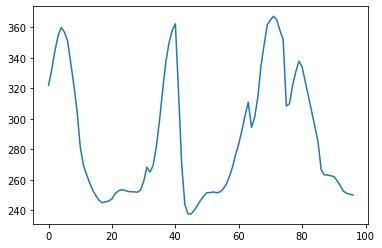

In [421]:
plt.plot(gru_outputs[0])
plt.show()

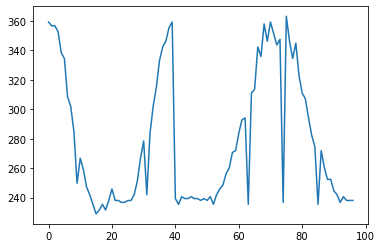

In [422]:
plt.plot(targets[0])
plt.show()